## Context
1. **Knowledge distillation (KD)** transfers a larger teacher model into a smaller student by matching soft outputs/logits, aiming for efficiency without sacrificing too much accuracy (Hinton et al., 2015, KD with KL loss on softened logits).
2. **Reference approach**: standard KD uses a KL loss on softened logits (temperature scaling) between teacher and student, plus the task loss.
3. **Relational Knowledge Distillation (RKD)** (Park et al., 2019) augments KD by aligning relational structure (pairwise distances/angles) between embeddings, not just logits.
4. **This notebook** shows how to reproduce the QRKD paper (*Quantum Relational Knowledge Distillation*, arXiv:2508.13054). The paper’s claim: adding a quantum-inspired fidelity kernel to RKD further improves student performance by aligning teacher/student relations in a richer Hilbert space, while keeping models fully classical at inference.

We can combine these components into a composite loss:
$$\mathcal{L} = L_{\text{task}} + \lambda_{\text{KD}} L_{\text{KD}} + \lambda_{d} L_{\text{RKD-dist}} + \lambda_{a} L_{\text{RKD-ang}} + \lambda_{q} L_{\text{fidelity}}$$
- $L_{\text{task}}$: cross-entropy on ground-truth labels.
- $L_{\text{KD}}$: KL on softened logits (temperature $T$), weighted by $\lambda_{\text{KD}}$.
- $L_{\text{RKD-dist}}$, $L_{\text{RKD-ang}}$: relational distance/angle losses (weights $\lambda_d, \lambda_a$).
- $L_{\text{fidelity}}$: fidelity kernel alignment between teacher/student normalized features (weight $\lambda_q$).

Below we compare KD, RKD, and QRKD on a small MNIST subset to illustrate these ideas.


# KD vs RKD vs QRKD (mini MNIST)

This walkthrough trains small teacher/student CNNs on a **10k subset of MNIST** for a few epochs to contrast classical distillation flavors:

- **KD**: match teacher logits (soft targets).
- **RKD**: match relational geometry (pairwise distances/angles) of teacher features.
- **QRKD**: extend RKD with a quantum-inspired fidelity kernel on normalized features (see the paper *Quantum Relational Knowledge Distillation*, arXiv:2508.13054, for the conceptual background: map features to a Hilbert space and align quantum kernels \|\u27e8\u03c6(x\_i)\|\u03c6(x\_j)\u27e9\|^2 to transfer richer relations).

We keep everything classical here by using quantum simulators (MerLin or Qiskit), but the same would of course apply on actual quantum hardware when simulation is not possible anymore; the quantum part is the fidelity kernel regularizer over feature vectors.

Runs are short (3 epochs) for quick comparison.

In [1]:
# Add project to path when running from repo root
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

ROOT = Path(".").resolve()
if str(ROOT / "QRKD") not in sys.path:
    sys.path.insert(0, str(ROOT / "QRKD"))

In [2]:
from lib.losses import DistillationLoss
from lib.models import StudentCNN, TeacherCNN
from lib.train import TrainConfig, train_student, train_teacher

/Users/senellart/DEV/reproduced_papers-jsenellart/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Hyperparameters for the quick demo
SEED = 1337
SUBSET_SIZE = 10_000  # use 10k samples from MNIST train split
BATCH_SIZE = 128
EPOCHS = 3
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE

device(type='cpu')

In [4]:
# Data: 10k MNIST subset for training, full 10k test for evaluation
tfm = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_full = datasets.MNIST("data", train=True, download=True, transform=tfm)
indices = torch.randperm(len(train_full))[:SUBSET_SIZE]
train_subset = Subset(train_full, indices)
test_set = datasets.MNIST("data", train=False, download=True, transform=tfm)

train_loader = DataLoader(
    train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_subset), len(test_set)

(10000, 10000)

In [5]:
# Helper: train teacher
def run_teacher():
    teacher = TeacherCNN().to(DEVICE)
    cfg = TrainConfig(epochs=EPOCHS, lr=LR, device=str(DEVICE), verbose=True)
    teacher, hist = train_teacher(teacher, train_loader, cfg, test_loader)
    return teacher, hist


teacher, hist_teacher = run_teacher()
hist_teacher

[Teacher] Params: 6,690


[Teacher] Epoch 1/3 - loss: 1.7415, train_acc: 70.77%, test_acc: 71.50%


[Teacher] Epoch 2/3 - loss: 0.6614, train_acc: 86.16%, test_acc: 85.67%


[Teacher] Epoch 3/3 - loss: 0.4175, train_acc: 90.13%, test_acc: 90.11%


{'loss': [1.7415213947054706, 0.6613982640489747, 0.4174973410141619],
 'train_acc': [70.77, 86.16, 90.13],
 'test_acc': [71.5, 85.67, 90.11]}

In [6]:
# Student variants
def run_student(student_name: str, weights: DistillationLoss, teacher_model=None):
    student = StudentCNN().to(DEVICE)
    cfg = TrainConfig(epochs=EPOCHS, lr=LR, device=str(DEVICE), verbose=True)
    result = train_student(
        student,
        teacher_model,
        train_loader,
        test_loader,
        cfg,
        weights,
        student_name=student_name,
    )
    return result["history"], result["test_acc"]


histories = {}
test_accs = {}

# Scratch
scratch_hist, scratch_acc = run_student(
    "student_scratch",
    DistillationLoss(kd=0.0, dr=0.0, ar=0.0, qk=0.0),
    teacher_model=None,
)
histories["Scratch"] = scratch_hist
test_accs["Scratch"] = scratch_acc

# KD
kd_weights = DistillationLoss(
    kd=0.5, dr=0.0, ar=0.0, qk=0.0, temperature=4.0, kd_alpha=0.5
)
kd_hist, kd_acc = run_student("student_kd", kd_weights, teacher_model=teacher)
histories["KD"] = kd_hist
test_accs["KD"] = kd_acc

# RKD
rkd_weights = DistillationLoss(
    kd=0.0, dr=0.1, ar=0.1, qk=0.0, temperature=4.0, kd_alpha=0.5
)
rkd_hist, rkd_acc = run_student("student_rkd", rkd_weights, teacher_model=teacher)
histories["RKD"] = rkd_hist
test_accs["RKD"] = rkd_acc

# QRKD (simple fidelity kernel on features)
qrkd_weights = DistillationLoss(
    kd=0.5,
    dr=0.1,
    ar=0.1,
    qk=0.1,
    qk_backend="merlin",  # use Merlïn fidelity kernel backend for the quantum relational term
    qk_n_modes=10,
    qk_n_photons=5,
    temperature=4.0,
    kd_alpha=0.5,
)
qrkd_hist, qrkd_acc = run_student("student_qrkd", qrkd_weights, teacher_model=teacher)
histories["QRKD"] = qrkd_hist
test_accs["QRKD"] = qrkd_acc

test_accs

[Student] student_scratch  Params: 1,725 | Teacher: None (scratch)


[Student] student_kd  Params: 1,725 | Teacher Params: 6,690


[Student] student_rkd  Params: 1,725 | Teacher Params: 6,690


[Student] student_qrkd  Params: 1,725 | Teacher Params: 6,690


{'Scratch': 38.68,
 'KD': 20.87,
 'RKD': 58.10999999999999,
 'QRKD': 53.269999999999996}

In [ ]:
# Per-epoch metrics for teacher and students
def fmt(val):
    return f"{val:.2f}" if val is not None else "na"


print("Teacher per-epoch:")
for ep, (loss, tr, te) in enumerate(
    zip(hist_teacher["loss"], hist_teacher["train_acc"], hist_teacher["test_acc"]), 1
):
    print(f"  Epoch {ep}: loss={loss:.4f}, train_acc={fmt(tr)}%, test_acc={fmt(te)}%")

for name in ["Scratch", "KD", "RKD", "QRKD"]:
    h = histories[name]
    print(f"{name} per-epoch:")
    for ep, (loss, t, d, tr, te) in enumerate(
        zip(h["loss"], h["task"], h["distill"], h["train_acc"], h["test_acc"]), 1
    ):
        print(
            f"  Epoch {ep}: loss={loss:.4f} (task={t:.4f}, distill={d:.4f}), train_acc={fmt(tr)}%, test_acc={fmt(te)}%"
        )

Teacher per-epoch:
  Epoch 1: loss=1.7415, train_acc=70.77%, test_acc=71.50%
  Epoch 2: loss=0.6614, train_acc=86.16%, test_acc=85.67%
  Epoch 3: loss=0.4175, train_acc=90.13%, test_acc=90.11%
Scratch per-epoch:
  Epoch 1: loss=2.2556 (task=2.2556, distill=0.0000), train_acc=18.83%, test_acc=18.57%
  Epoch 2: loss=2.0323 (task=2.0323, distill=0.0000), train_acc=35.90%, test_acc=36.66%
  Epoch 3: loss=1.7560 (task=1.7560, distill=0.0000), train_acc=38.58%, test_acc=38.68%
KD per-epoch:
  Epoch 1: loss=4.0488 (task=2.2634, distill=1.7854), train_acc=10.34%, test_acc=10.41%
  Epoch 2: loss=3.7640 (task=2.1318, distill=1.6322), train_acc=19.91%, test_acc=20.35%
  Epoch 3: loss=3.5924 (task=2.0598, distill=1.5325), train_acc=20.18%, test_acc=20.87%
RKD per-epoch:
  Epoch 1: loss=2.1639 (task=2.1337, distill=0.0303), train_acc=38.17%, test_acc=38.15%
  Epoch 2: loss=1.6603 (task=1.6338, distill=0.0265), train_acc=52.02%, test_acc=52.17%
  Epoch 3: loss=1.4213 (task=1.3945, distill=0.0268), t

In [8]:
# Summarize final accuracy
from pprint import pprint

summary = {
    "Teacher train": hist_teacher["train_acc"][-1],
    "Teacher test": hist_teacher["test_acc"][-1],
}
for name in ["Scratch", "KD", "RKD", "QRKD"]:
    h = histories[name]
    summary[f"{name} train"] = h["train_acc"][-1]
    summary[f"{name} test"] = h["test_acc"][-1]

pprint(summary)

{'KD test': 20.87,
 'KD train': 20.18,
 'QRKD test': 53.269999999999996,
 'QRKD train': 53.39,
 'RKD test': 58.10999999999999,
 'RKD train': 57.42,
 'Scratch test': 38.68,
 'Scratch train': 38.58,
 'Teacher test': 90.11,
 'Teacher train': 90.13}


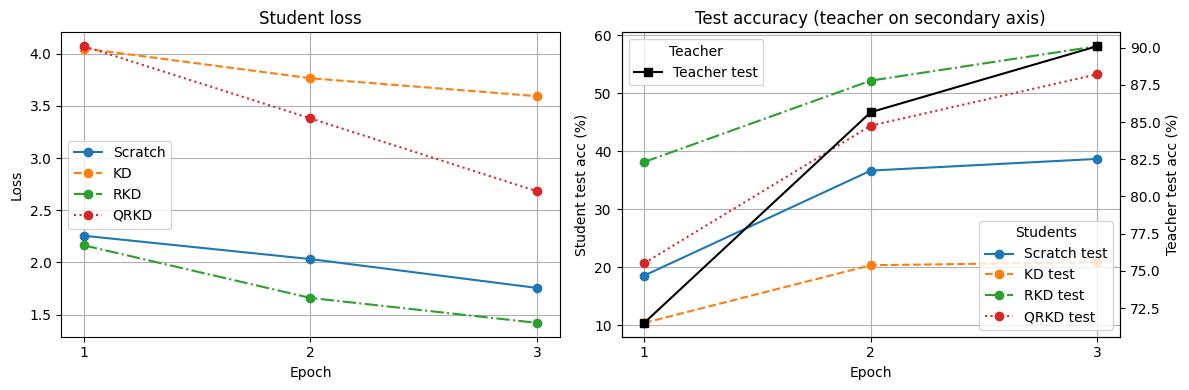

In [9]:
# Plots: loss and test accuracy (teacher on secondary axis for clarity)
epochs = range(1, EPOCHS + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss (students only)
ax_loss = axes[0]
for name, style in zip(["Scratch", "KD", "RKD", "QRKD"], ["-", "--", "-.", ":"]):
    loss_curve = histories[name]["loss"]
    ax_loss.plot(epochs, loss_curve, label=name, linestyle=style, marker="o")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("Student loss")
ax_loss.set_xticks(list(epochs))
ax_loss.legend()
ax_loss.grid(True)

# Test accuracy (teacher on secondary axis)
ax_acc = axes[1]
ax_acc2 = ax_acc.twinx()
teacher_test = hist_teacher["test_acc"]
teacher_line = ax_acc2.plot(
    epochs, teacher_test, label="Teacher test", color="black", linestyle="-", marker="s"
)[0]
ax_acc2.set_ylabel("Teacher test acc (%)", color="black")
ax_acc2.tick_params(axis="y", labelcolor="black")
ax_acc2.set_xticks(list(epochs))

student_lines = []
for name, style, color in zip(
    ["Scratch", "KD", "RKD", "QRKD"], ["-", "--", "-.", ":"], ["C0", "C1", "C2", "C3"]
):
    test_curve = histories[name]["test_acc"]
    line = ax_acc.plot(
        epochs,
        test_curve,
        label=f"{name} test",
        linestyle=style,
        marker="o",
        color=color,
    )[0]
    student_lines.append(line)
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Student test acc (%)")
ax_acc.set_title("Test accuracy (teacher on secondary axis)")
ax_acc.set_xticks(list(epochs))
leg1 = ax_acc.legend(handles=student_lines, loc="lower right", title="Students")
leg2 = ax_acc2.legend(handles=[teacher_line], loc="upper left", title="Teacher")
ax_acc.grid(True)

plt.tight_layout()
plt.show()

## Running the full QRKD suite on other datasets

The project ships a bash orchestrator to train all variants (teacher, scratch, KD, RKD, QRKD-simple, QRKD-merlin; QRKD-qiskit optional) on MNIST or CIFAR-10 and produce ready-to-use reports/plots:

```bash
bash QRKD/utils/run_full_suite.sh --dataset cifar10 --epochs 10
# or mnist
bash QRKD/utils/run_full_suite.sh --dataset mnist --epochs 10
```

Variants and losses:
- Scratch: task CE only.
- KD: task CE + KL on softened logits (temperature, alpha).
- RKD: task CE + relational distances/angles.
- QRKD-simple: task CE + KD + RKD + classical fidelity kernel (|⟨ψ_i|ψ_j⟩|² over normalized features).
- QRKD-merlin: same but using Merlïn fidelity kernel backend.
- QRKD-qiskit (optional, slower): using Qiskit fidelity kernel backend.

Artifacts land in `results/` with dataset/epoch suffixes (e.g., `report_cifar10_10epochs.txt`, `accuracy_plot_cifar10_10epochs.png`). Below is the precomputed CIFAR-10 plot from `results/accuracy_plot_cifar10_10epochs.png`:

![CIFAR-10 test curves](results/accuracy_plot_cifar10_10epochs.png)
